# Interactions - Lab

## Introduction

In this lab, you'll explore interactions in the Boston Housing data set.

## Objectives

You will be able to:
- Understand what interactions are
- Understand how to accommodate for interactions in regression

## Build a baseline model 

You'll use a couple of built-in functions, which we imported for you below.

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Import the Boston data set using `load_boston()`. We won't bother to preprocess the data in this lab. If you still want to build a model in the end, you can do that, but this lab will just focus on finding meaningful insights in interactions and how they can improve $R^2$ values.

In [2]:
regression = LinearRegression()
boston = load_boston()

Create a baseline model which includes all the variables in the Boston housing data set to predict the house prices. The use 10-fold cross-validation and report the mean $R^2$ value as the baseline $R^2$.

In [5]:
## code here
crossvalidation = KFold(n_splits=10,shuffle=True, random_state=42)
baseline = np.mean(cross_val_score(regression, X=boston.data, y=boston.target, scoring='r2', cv=crossvalidation))

In [6]:
baseline

0.717068752774469

## See how interactions improve your baseline

Next, create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the R^2. We'll look at the 3 interactions which have the biggest effect on our R^2, so print out the top 3 combinations.

You will create a for loop to loop through all the combinations of 2 predictors. You can use `combinations` from itertools to create a list of all the pairwise combinations. To find more info on how this is done, have a look [here](https://docs.python.org/2/library/itertools.html).

In [7]:
from itertools import combinations
combinations = list(combinations(boston.feature_names, 2))

In [10]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [11]:
## code to find top 3 interactions by R^2 value here
interaction_scores = []
for combo in combinations:
    df["interaction"] = df[combo[0]]*df[combo[1]]
    crossvalidation = KFold(n_splits=10,shuffle=True, random_state=42)
    interaction_score = np.mean(cross_val_score(regression, X=df.values, y=boston.target, 
                                                scoring='r2', cv=crossvalidation))
    if interaction_score > baseline:
        interaction_scores.append((combo[0], combo[1], interaction_score))

In [14]:
interaction_scores = sorted(interaction_scores, key=lambda inter: inter[2], reverse=True)
interaction_scores[:3]

[('RM', 'LSTAT', 0.7826199503986451),
 ('RM', 'TAX', 0.7717836595567208),
 ('RM', 'RAD', 0.7661601104295918)]

## Look at the top 3 interactions: "RM" as a confounding factor

The top three interactions seem to involve "RM", the number of rooms as a confounding variable for all of them. Let's have a look at interaction plots for all three of them. This exercise will involve:

- splitting our data up in 3 groups: one for houses with a few rooms, one for houses with a "medium" amount of rooms, one for a high amount of rooms.
- Create a function `build_interaction_rm`. This function takes an argument `varname` (which can be set equal to the column name as a string) and a column `description` (which describes the variable or varname, to be included on the x-axis of the plot). The function outputs a plot that uses "RM" as a confounding factor. 

We split the data set for high, medium and low amount of rooms for you.

In [26]:
df_target = pd.DataFrame(boston.target, columns=['target'])
alldata = pd.concat([df, df_target], axis=1)
alldata.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,interaction,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,1976.5620,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,3627.6660,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,1583.1049,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,1160.2122,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,2115.4770,36.2


In [27]:
rm = np.asarray(df[["RM"]]).reshape(len(df[["RM"]]))

In [28]:
high_rm = alldata[rm > np.percentile(rm, 67)]
med_rm = alldata[(rm > np.percentile(rm, 33)) & (rm <= np.percentile(rm, 67))]
low_rm = alldata[rm <= np.percentile(rm, 33)]

Create `build_interaction_rm`.

In [29]:
def build_interaction_rm(varname, description):
    regression_h = LinearRegression()
    regression_m = LinearRegression()
    regression_l = LinearRegression()
    regression_h.fit(high_rm[varname].values.reshape(-1, 1), high_rm["target"])
    regression_m.fit(med_rm[varname].values.reshape(-1, 1), med_rm["target"])
    regression_l.fit(low_rm[varname].values.reshape(-1, 1), low_rm["target"])

    # Make predictions using the testing set
    pred_high = regression_h.predict(high_rm[varname].values.reshape(-1, 1))
    pred_med = regression_m.predict(med_rm[varname].values.reshape(-1, 1))
    pred_low = regression_l.predict(low_rm[varname].values.reshape(-1, 1))

    # The coefficients
    print(regression_h.coef_)
    print(regression_m.coef_)
    print(regression_l.coef_)

    # Plot outputs
    plt.figure(figsize=(12,7))
    plt.scatter(high_rm[varname], high_rm["target"],  color='blue', alpha = 0.3, label = "more rooms")
    plt.scatter(med_rm[varname], med_rm["target"],  color='red', alpha = 0.3, label = "medium rooms")
    plt.scatter(low_rm[varname], low_rm["target"],  color='orange', alpha = 0.3, label = "low amount of rooms")

    plt.plot(low_rm[varname], pred_low,  color='orange', linewidth=2)
    plt.plot(med_rm[varname], pred_med,  color='red', linewidth=2)
    plt.plot(high_rm[varname], pred_high,  color='blue', linewidth=2)
    plt.ylabel("house value")
    plt.xlabel(description)
    plt.legend()

Next, use build_interaction_rm with the three variables that came out with the highest effect on $R^2$

[13.97372526]
[2.23033521]
[2.3655758]


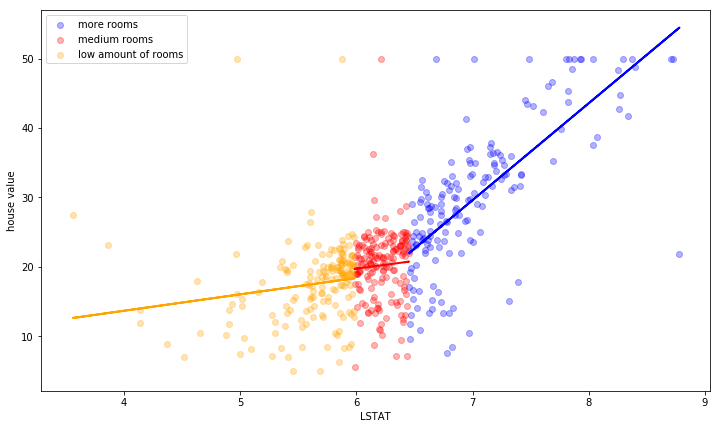

In [30]:
# first plot
build_interaction_rm('RM', 'LSTAT')

[13.97372526]
[2.23033521]
[2.3655758]


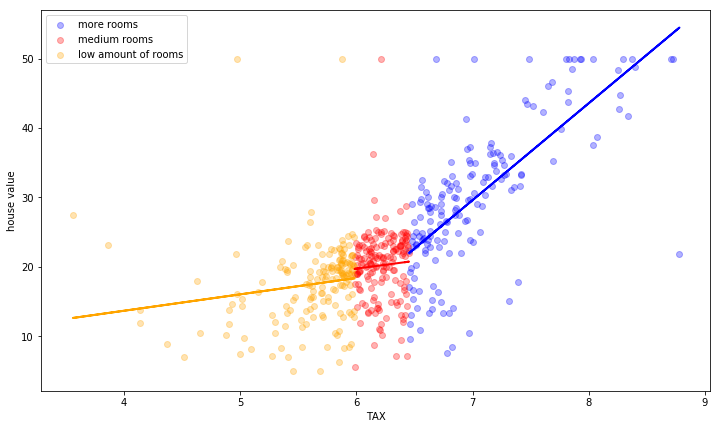

In [31]:
# second plot
build_interaction_rm('RM', 'TAX')

[13.97372526]
[2.23033521]
[2.3655758]


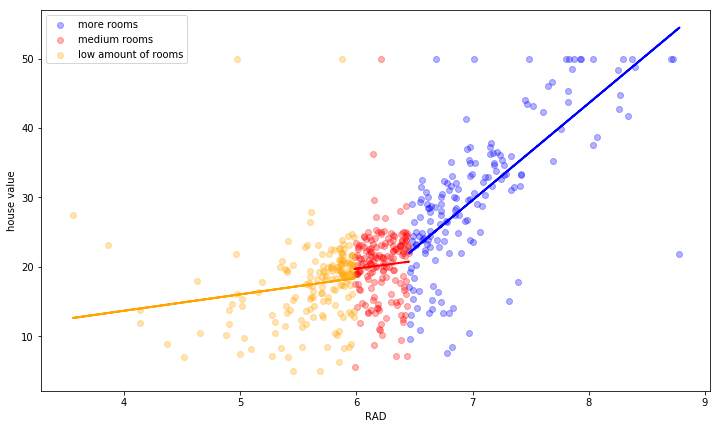

In [32]:
# third plot
build_interaction_rm('RM', 'RAD')

## Build a final model including all three interactions at once

Use 10-fold crossvalidation.

In [34]:
# code here
final_df = df.copy()
for interaction_score in interaction_scores[:3]:
    c1 = final_df[interaction_score[0]]
    c2 = final_df[interaction_score[1]]
    col_name = "{}_{}".format(interaction_score[0], interaction_score[1])
    
    final_df[col_name] = c1*c2
final_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,interaction,RM_LSTAT,RM_TAX,RM_RAD
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,1976.5620,32.74350,1946.200,6.575
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,3627.6660,58.68794,1553.882,12.842
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,1583.1049,28.95555,1738.770,14.370
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,1160.2122,20.57412,1553.556,20.994
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,2115.4770,38.09351,1586.634,21.441


In [36]:
## code here
crossvalidation = KFold(n_splits=10,shuffle=True, random_state=42)
final_score = np.mean(cross_val_score(regression, X=final_df.values, y=boston.target, scoring='r2', cv=crossvalidation))
final_score

0.7833909250720847

Our $R^2$ has increased considerably! Let's have a look in statsmodels to see if all these interactions are significant.

In [39]:
# code here
import statsmodels.api as sm
df_inter_sm = sm.add_constant(final_df)
model = sm.OLS(boston.target,df_inter_sm)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     126.6
Date:                Sun, 18 Nov 2018   Prob (F-statistic):          1.70e-166
Time:                        11:57:55   Log-Likelihood:                -1413.1
No. Observations:                 506   AIC:                             2862.
Df Residuals:                     488   BIC:                             2938.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -16.7964      7.613     -2.206      0.028     -31.756      -1.837
CRIM           -0.1616      0.028     -5.737      0.000      -0.217      -0.106
ZN              0.0173      0.012      1.459      0.145      -0.006       0.041
INDUS           0.0947      0.053      1.793      0.074      -0.009       0.198
CHAS            2.6094      0.740      3.527      0.000       1.156       4.063
NOX           -13.4938      3.275     -4.120      0.000     -19.929      -7.059
RM             10.6938      0.992     10.782      0.000       8.745      12.643
AGE             0.0073      0.011      0.633      0.527      -0.015       0.030
DIS            -0.9516      0.175     -5.453      0.000      -1.294      -0.609
RAD             0.6607      0.478      1.383      0.167      -0.278       1.599
TAX             0.0344      0.025      1.401      0.162      -0.014       0.083
PTRATIO        -0.6962      0.113     -6.153      0.000      -0.919      -0.474
B               0.0127      0.007      1.795      0.073      -0.001       0.027
LSTAT           1.2734      0.253      5.041      0.000       0.777       1.770
interaction    -0.0004      0.000     -1.165      0.245      -0.001       0.000
RM_LSTAT       -0.2904      0.041     -7.135      0.000      -0.370      -0.210
RM_TAX         -0.0074      0.004     -1.870      0.062      -0.015       0.000
RM_RAD         -0.0620      0.078     -0.792      0.428      -0.216       0.092
==============================================================================
Omnibus:                      252.490   Durbin-Watson:                   1.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2472.595
Skew:                           1.945   Prob(JB):                         0.00
Kurtosis:                      13.107   Cond. No.                     2.40e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

What is your conclusion here?

In [ ]:
# formulate your conclusion

## Summary

You now understand how to include interaction effects in your model!